In [1]:
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
import numpy as np
import time
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications.resnet50 import preprocess_input

In [13]:
import os
project_base_dir = 'big-data-project/'
train_data_dir = os.path.join(project_base_dir, "data", "train")
test_data_dir = os.path.join(project_base_dir, "data", "test")
img_width = 1024
img_height = 1024
channel = 3
input_img = Input(shape = (img_width, img_height, channel))
epochs = 20
batch_size = 8 #vary this parameter depending on your GPU capacity
num_classes= 2 #[pneumonia, normal] [bacterial, viral]

In [3]:
from tensorflow.config import list_physical_devices
print("Num GPUs Available: ", len(list_physical_devices('GPU')))

Num GPUs Available:  1


2021-12-08 17:48:01.447645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 17:48:01.558373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 17:48:01.559037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [16]:
base_model = applications.ResNet50(
    weights='imagenet', include_top=False,
    input_shape=(img_width,img_height,channel))
base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False
    
# addind the top layers
x = base_model(base_model.input, training=False)
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.2)(x)  # Regularize with dropout
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                   rotation_range=40, shear_range=0.2,
                                   zoom_range=0.2, horizontal_flip=True,
                                   validation_split=0.2) #taking 20% of training for validation 

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(1024, 1024),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(1024, 1024),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(1024, 1024),
        batch_size=batch_size,
        class_mode='categorical',shuffle=False)

nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

Found 6214 images belonging to 2 classes.
Found 1552 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
# Allocate balanced weights to penalize over-represented classes
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
                class_weight='balanced',
                classes=np.unique(train_generator.classes), 
                y=train_generator.classes)
class_weights = {i:weight for i, weight in enumerate(class_weights)}
print(class_weights)

{0: 1.0, 1: 1.0}


In [7]:
optimizer = Adam(learning_rate=0.001) # SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

#compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['acc'])

#compute the training time
start = time.time()

#give the path to store the model weights
filepath = 'weights/' + model.name + '.{epoch:02d}-{val_acc:.4f}.hdf5'
filepath = os.path.join(project_base_dir, filepath)

#save only the best weights
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                              save_weights_only=True, save_best_only=True, 
                             mode='max', save_freq='epoch')

#visualize model performance using TensorBoard
logs_dir = os.path.join(project_base_dir, "logs/")
tensor_board = TensorBoard(log_dir=logs_dir, histogram_freq=0)
callbacks_list = [checkpoint, tensor_board]

#train model
resnet50_history = model.fit(
    train_generator,
    workers=10,
    max_queue_size=320,
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks_list,
    # class_weight = class_weights,
    validation_steps=nb_validation_samples // batch_size,
    verbose=1)

#print the total time taken for training
print(time.time()-start)

/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20


2021-12-08 17:49:41.119448: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200


388/388 [==============================] - ETA: 0s - loss: 0.2023 - acc: 0.9287
Epoch 00001: val_acc improved from -inf to 0.94137, saving model to big-data-project/weights/model.01-0.9414.hdf5
388/388 [==============================] - 858s 2s/step - loss: 0.2023 - acc: 0.9287 - val_loss: 0.1637 - val_acc: 0.9414
Epoch 2/20
388/388 [==============================] - ETA: 0s - loss: 0.1281 - acc: 0.9542
Epoch 00002: val_acc improved from 0.94137 to 0.95876, saving model to big-data-project/weights/model.02-0.9588.hdf5
388/388 [==============================] - 812s 2s/step - loss: 0.1281 - acc: 0.9542 - val_loss: 0.1255 - val_acc: 0.9588
Epoch 3/20
388/388 [==============================] - ETA: 0s - loss: 0.1031 - acc: 0.9642
Epoch 00003: val_acc improved from 0.95876 to 0.96521, saving model to big-data-project/weights/model.03-0.9652.hdf5
388/388 [==============================] - 826s 2s/step - loss: 0.1031 - acc: 0.9642 - val_loss: 0.1077 - val_acc: 0.9652
Epoch 4/20
388/388 [====

In [17]:
## Loading best model
weights_path = "big-data-project/weights/model.20-0.9820.hdf5"
model.load_weights(weights_path)

## Setting weights of the entire network as trainable
model.trainable = True
for layer in base_model.layers:
    layer.trainable = True

## Summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1024, 1024, 3)]   0         
                                                                 
 resnet50 (Functional)       (None, 32, 32, 2048)      23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 predictions (Dense)         (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [18]:
optimizer = SGD(learning_rate=1e-4, momentum=0.9)
# optimizer = Adam(1e-5)
model.compile(
    optimizer=optimizer,  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['acc'],
)

#give the path to store the model weights
filepath = 'big-data-project/weights_fine_tune/' + model.name + '.{epoch:02d}-{val_acc:.4f}.hdf5'
# filepath = os.path.join(project_base_dir, filepath)

#save only the best weights
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_weights_only=True, save_best_only=True, 
                             mode='max', save_freq='epoch')

# logs_dir = os.path.join(project_base_dir, "logs2/")
logs_dir = "big-data-project/logs_fine_tune/"
tensor_board = TensorBoard(log_dir=logs_dir, histogram_freq=0, batch_size=batch_size)
callbacks_list = [checkpoint, tensor_board]

epochs = 10
model.fit(
    train_generator,
    workers=10, max_queue_size=100,
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks_list,
    validation_steps=nb_validation_samples // batch_size,
    verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/10
887/887 [==============================] - ETA: 0s - loss: 0.3636 - acc: 0.8759
Epoch 00001: val_acc improved from -inf to 0.85908, saving model to big-data-project/weights_fine_tune/model_1.01-0.8591.hdf5
887/887 [==============================] - 1599s 2s/step - loss: 0.3636 - acc: 0.8759 - val_loss: 0.2886 - val_acc: 0.8591
Epoch 2/10
887/887 [==============================] - ETA: 0s - loss: 0.1421 - acc: 0.9497
Epoch 00002: val_acc improved from 0.85908 to 0.94312, saving model to big-data-project/weights_fine_tune/model_1.02-0.9431.hdf5
887/887 [==============================] - 1567s 2s/step - loss: 0.1421 - acc: 0.9497 - val_loss: 0.1580 - val_acc: 0.9431
Epoch 3/10
887/887 [==============================] - ETA: 0s - loss: 0.1148 - acc: 0.9602
Epoch 00003: val_acc improved from 0.94312 to 0.94635, saving model to big-data-project/weights_fine_tune/model_1.03-0.9463.hdf5
887/887 [==============================] - 1567s 2s/step - loss: 0.1148 - acc: 0.9602 - val_loss:

In [19]:
## Testing the model's performance
model.load_weights('big-data-project/weights_fine_tune/model_1.07-0.9644.hdf5') #change this to your path and model weights

#Computing accuracy for test set
resnet_pred = model.predict(test_generator, nb_test_samples/batch_size, workers=4)

#true labels
Y_test = test_generator.classes

#print the shape of y_pred and Y_test
print(resnet_pred.shape)
print(Y_test.shape)

#measure accuracy
resnet_acc = accuracy_score(Y_test,resnet_pred.argmax(axis=-1))
print('The accuracy of custom ResNet50 model is: ', resnet_acc)

(624, 2)
(624,)
The accuracy of custom ResNet50 model is:  0.9230769230769231


In [65]:
# Print classification report
target_names = ['class 0(normal)', 'class 1(pneumonia)'] #from the generator.class_indices
print(classification_report(Y_test, resnet_pred.argmax(axis=-1), target_names=target_names, digits=4))

                    precision    recall  f1-score   support

   class 0(normal)     0.9745    0.8162    0.8884       234
class 1(pneumonia)     0.8995    0.9872    0.9413       390

          accuracy                         0.9231       624
         macro avg     0.9370    0.9017    0.9148       624
      weighted avg     0.9276    0.9231    0.9215       624



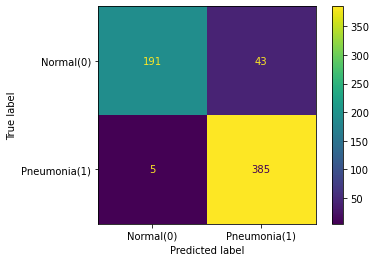

In [23]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, resnet_pred.argmax(axis=-1))
cm_disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=["Normal(0)", "Pneumonia(1)"])
cm_disp.plot()

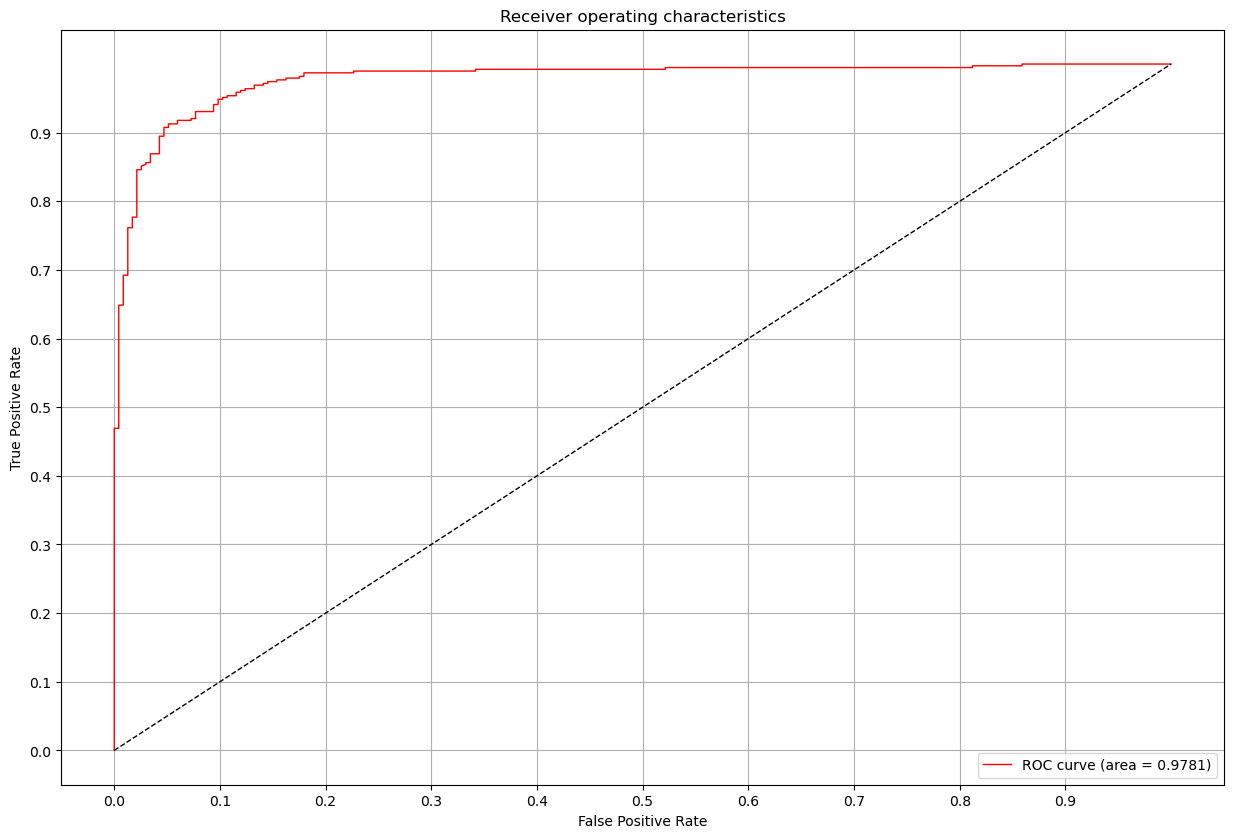

In [24]:
# Compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, resnet_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.10)
minor_ticks = np.arange(0.0, 1.0, 0.10)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

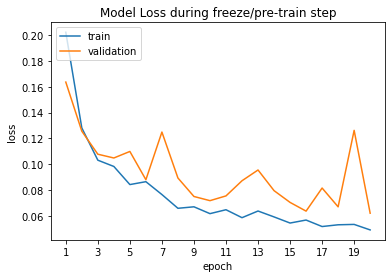

In [62]:
# Loss history during freeze/pre-train step
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

_, ax = plt.subplots()
ax.plot(resnet50_history.history['loss'])
ax.plot(resnet50_history.history['val_loss'])
ax.set_title('Model Loss during freeze/pre-train step')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
ax.set_xticks(range(0, 20, 2))
ax.set_xticklabels(range(1, 21, 2))
plt.show()

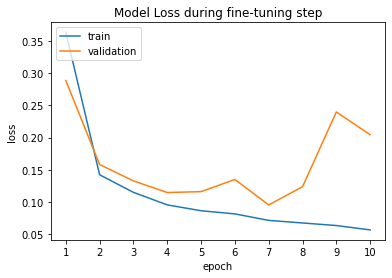

In [64]:
# Loss history during fine-tuning
history = dict()
history["loss"] = [0.3636, 0.1421, 0.1148, 0.0953, 0.0862, 0.0813, 0.0712, 0.0672, 0.0632, 0.0564]
history["val_loss"] = [0.2886, 0.1580, 0.1326, 0.1145, 0.1159, 0.1348, 0.0952, 0.1235, 0.2397, 0.2043]

_, ax = plt.subplots()
ax.plot(history['loss'])
ax.plot(history['val_loss'])
ax.set_title('Model Loss during fine-tuning step')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.set_xticks(range(0, 10))
ax.set_xticklabels(range(1, 11))
ax.legend(['train', 'validation'], loc='upper left')
plt.show()